In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer


csv_files = [
    "../data/Annotated/Petyr_Baelish.csv",
    "../data/Annotated/Sam_Tarly.csv",
    "../data/Annotated/Theon_Greyjoy.csv",
]

dfs = []
for f in csv_files:
    df = pd.read_csv(f)
    # set standard for character name
    df["Character"] = df["Name"].str.title()
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# save the raw that only reserve the topics and sentences
data = data.dropna(subset=["Sentence", "Unique Coding"])

print("数据行数：", len(data))
print("角色：", data["Character"].unique())
print("主题(Unique Coding)：", data["Unique Coding"].unique())

data = data.rename(columns={"Unique Coding": "Topic"})


# 1. Topic distribution per character 
topic_per_char = (
    data.groupby(["Character", "Topic"])
        .size()
        .reset_index(name="Count")
        .pivot(index="Character", columns="Topic", values="Count")
        .fillna(0)
        .astype(int)
)

print("\n=== Topic distribution per character (count of topics per character) ===")
print(topic_per_char)

# create new csv
topic_per_char.to_csv("topic_distribution_per_character.csv")

# 2. Global distribution 
global_topic_dist = (
    data["Topic"]
    .value_counts()
    .rename_axis("Topic")
    .reset_index(name="Count")
)

print("\n=== Global topic distribution (all characters) ===")
print(global_topic_dist)

global_topic_dist.to_csv("global_topic_distribution.csv", index=False)

# 3. Per-season per-character distribution 
per_season_char_topic = (
    data.groupby(["Season", "Character", "Topic"])
        .size()
        .reset_index(name="Count")
)

print("\n=== Per-season per-character topic counts (long format) ===")
print(per_season_char_topic.head())

# raw=Season+Character,colomn=Topic
per_season_char_pivot = per_season_char_topic.pivot_table(
    index=["Season", "Character"],
    columns="Topic",
    values="Count",
    fill_value=0,
    aggfunc="sum"
)

print("\n=== Per-season per-character topic pivot table ===")
print(per_season_char_pivot.head())

per_season_char_topic.to_csv("per_season_per_character_topic_counts.csv", index=False)
per_season_char_pivot.to_csv("per_season_per_character_topic_pivot.csv")

# 4. Global per-season topic distribution 
global_season_topic = (
    data.groupby(["Season", "Topic"])
        .size()
        .reset_index(name="Count")
)

print("\n=== Global per-season topic distribution ===")
print(global_season_topic.head())

global_season_topic.to_csv("global_per_season_topic_distribution.csv", index=False)

# 5. TF-IDF: 找出每个 Topic 内 tf-idf 最高的10个词
# 先把同一 Topic 的句子拼成一个文档
topic_docs = (
    data.groupby("Topic")["Sentence"]
        .apply(lambda s: " ".join(str(x) for x in s))
)

print("\n=== 每个 Topic 合并后的文档数 ===")
print(topic_docs.shape)

# create TF-IDF vector
vectorizer = TfidfVectorizer(
    stop_words="english",
    lowercase=True,
    max_df=0.8,
    min_df=1,
)

tfidf_matrix = vectorizer.fit_transform(topic_docs.values)
feature_names = np.array(vectorizer.get_feature_names_out())

topic_labels = topic_docs.index.tolist()
top_n = 10

rows = []
for i, topic in enumerate(topic_labels):
    row = tfidf_matrix[i].toarray().ravel()
    # from large to small
    top_indices = row.argsort()[::-1][:top_n]
    top_terms = feature_names[top_indices]
    top_scores = row[top_indices]
    for term, score in zip(top_terms, top_scores):
        rows.append({"Topic": topic, "Term": term, "TFIDF": float(score)})

top_terms_df = pd.DataFrame(rows)

print("\n=== Top 10 TF-IDF terms per Topic ===")
for topic in topic_labels:
    print(f"\n### Topic: {topic}")
    display(
        top_terms_df[top_terms_df["Topic"] == topic]
        .sort_values("TFIDF", ascending=False)
        .head(top_n)
    )

top_terms_df.to_csv("top_10_tfidf_terms_per_topic.csv", index=False)

数据行数： 1460
角色： ['Petyr Baelish' 'Sam Tarly' 'Theon Greyjoy']
主题(Unique Coding)： ['Politics' 'War/Violence' 'People' 'Plans/Strategy/Advice'
 'Information/Lore' 'Orders/Demands' 'Loyalty/Honour' 'Trivial']

=== Topic distribution per character (count of topics per character) ===
Topic          Information/Lore  Loyalty/Honour  Orders/Demands  People  \
Character                                                                 
Petyr Baelish                77              51              24      70   
Sam Tarly                   115              39              58     105   
Theon Greyjoy                95              68              69      47   

Topic          Plans/Strategy/Advice  Politics  Trivial  War/Violence  
Character                                                              
Petyr Baelish                    113        52       40            22  
Sam Tarly                         77        30       92            40  
Theon Greyjoy                     47        35       38  

,Topic,Term,TFIDF
0,Information/Lore,wall,0.142306
1,Information/Lore,night,0.139368
2,Information/Lore,citadel,0.128352
3,Information/Lore,high,0.127493
4,Information/Lore,escape,0.126771
5,Information/Lore,saw,0.114028
6,Information/Lore,took,0.112536
7,Information/Lore,dragonglass,0.106244
8,Information/Lore,ice,0.101417
9,Information/Lore,wanted,0.099614



### Topic: Loyalty/Honour


,Topic,Term,TFIDF
10,Loyalty/Honour,serve,0.174576
11,Loyalty/Honour,promise,0.168591
12,Loyalty/Honour,save,0.168591
13,Loyalty/Honour,help,0.135489
14,Loyalty/Honour,honor,0.134873
15,Loyalty/Honour,defend,0.134873
16,Loyalty/Honour,yara,0.127554
17,Loyalty/Honour,queen,0.127554
18,Loyalty/Honour,gave,0.127554
19,Loyalty/Honour,failed,0.120698



### Topic: Orders/Demands


,Topic,Term,TFIDF
20,Orders/Demands,stop,0.243391
21,Orders/Demands,inside,0.183826
22,Orders/Demands,mercy,0.164506
23,Orders/Demands,leave,0.153888
24,Orders/Demands,wait,0.139080
25,Orders/Demands,safe,0.139080
26,Orders/Demands,hear,0.137009
27,Orders/Demands,speak,0.118970
28,Orders/Demands,pyp,0.118970
29,Orders/Demands,alright,0.118970



### Topic: People


,Topic,Term,TFIDF
30,People,reek,0.491800
31,People,beautiful,0.207073
32,People,theon,0.160710
33,People,archmaester,0.155305
34,People,petyr,0.143166
35,People,arryn,0.129421
36,People,thing,0.125198
37,People,children,0.113474
38,People,brienne,0.107375
39,People,warrior,0.107375



### Topic: Plans/Strategy/Advice


,Topic,Term,TFIDF
40,Plans/Strategy/Advice,make,0.211564
41,Plans/Strategy/Advice,north,0.186674
42,Plans/Strategy/Advice,safe,0.157913
43,Plans/Strategy/Advice,return,0.149426
44,Plans/Strategy/Advice,help,0.125802
45,Plans/Strategy/Advice,try,0.111824
46,Plans/Strategy/Advice,fight,0.108063
47,Plans/Strategy/Advice,happy,0.104359
48,Plans/Strategy/Advice,need,0.099559
49,Plans/Strategy/Advice,black,0.099559



### Topic: Politics


,Topic,Term,TFIDF
50,Politics,grace,0.396038
51,Politics,queen,0.279633
52,Politics,aegon,0.176402
53,Politics,realm,0.139817
54,Politics,marrying,0.132302
55,Politics,single,0.132302
56,Politics,north,0.132225
57,Politics,crown,0.127573
58,Politics,heir,0.127573
59,Politics,tywin,0.127573



### Topic: Trivial


,Topic,Term,TFIDF
60,Trivial,walks,0.250289
61,Trivial,work,0.167809
62,Trivial,turns,0.167809
63,Trivial,sam,0.158703
64,Trivial,jr,0.150173
65,Trivial,knife,0.150173
66,Trivial,looks,0.144805
67,Trivial,library,0.144805
68,Trivial,door,0.125857
69,Trivial,steps,0.125857



### Topic: War/Violence


,Topic,Term,TFIDF
70,War/Violence,kill,0.341430
71,War/Violence,killed,0.297787
72,War/Violence,walker,0.190046
73,War/Violence,white,0.160673
74,War/Violence,killing,0.132728
75,War/Violence,war,0.114533
76,War/Violence,throat,0.114533
77,War/Violence,gregor,0.106182
78,War/Violence,took,0.100420
79,War/Violence,arrows,0.095023


Topics: ['Information/Lore', 'Loyalty/Honour', 'Orders/Demands', 'People', 'Plans/Strategy/Advice', 'Politics', 'Trivial', 'War/Violence']


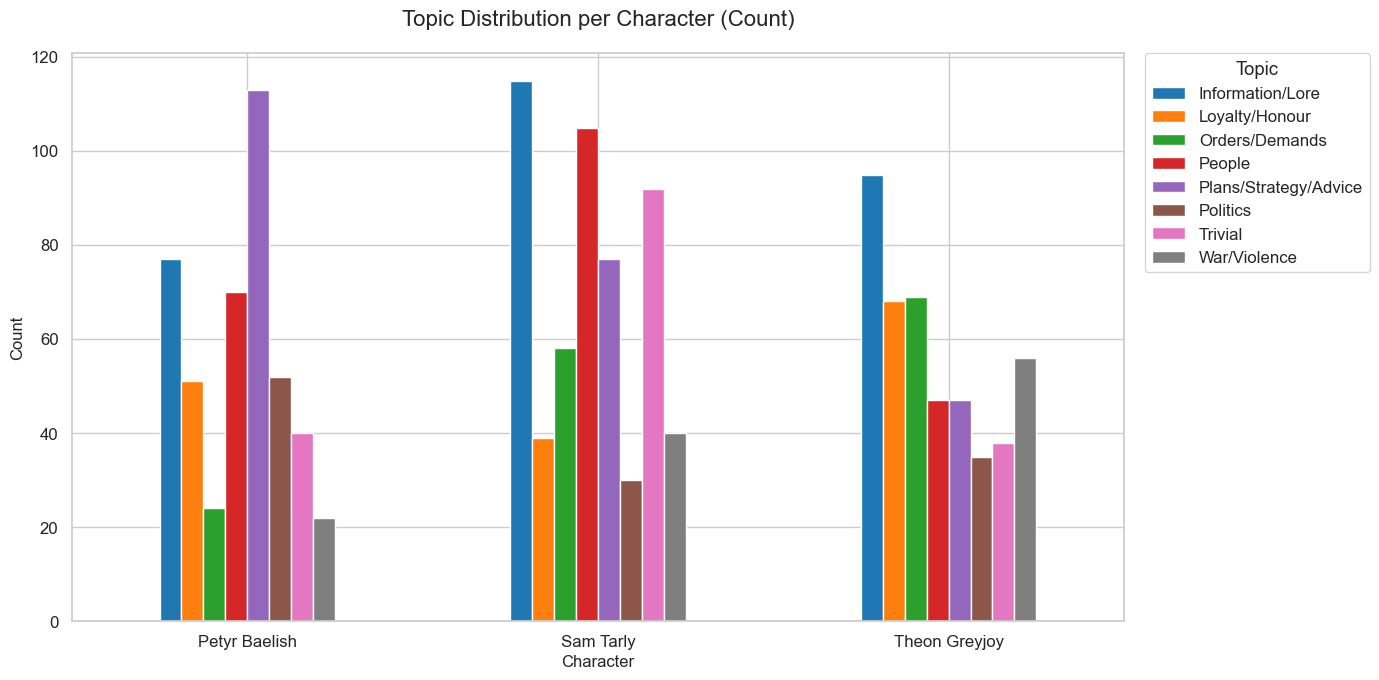

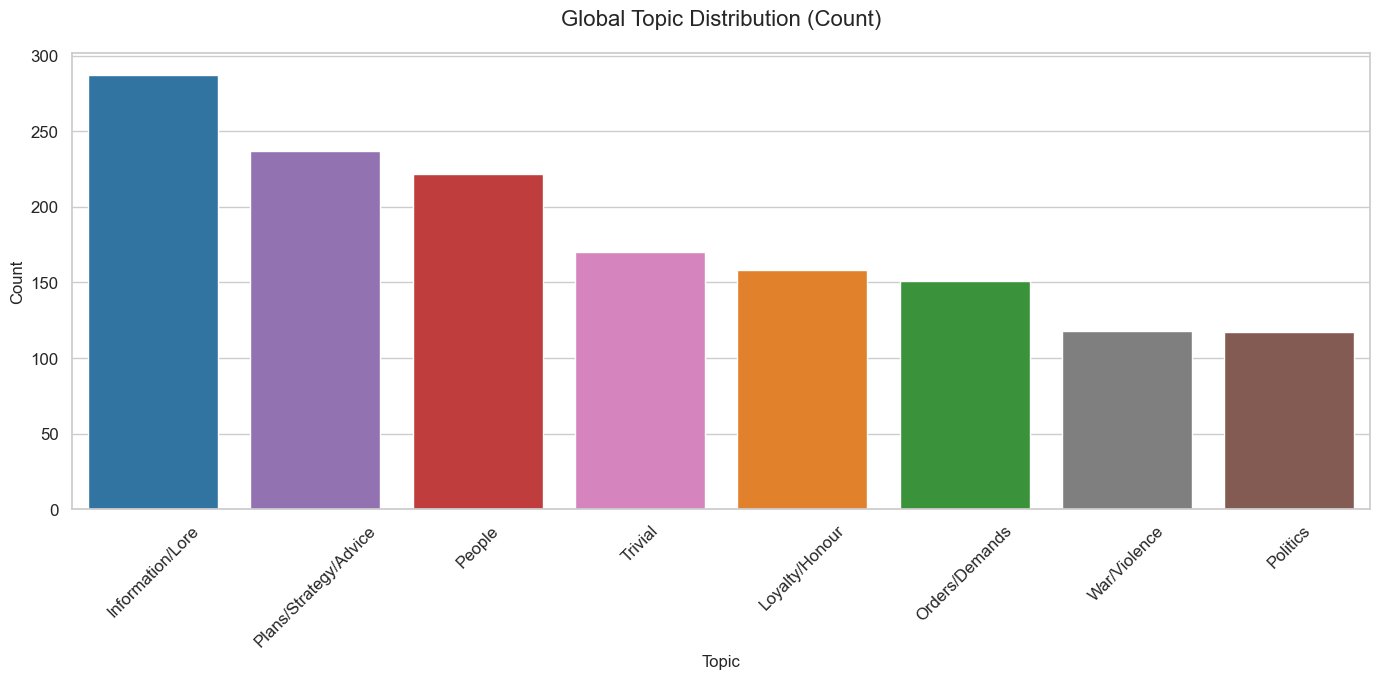

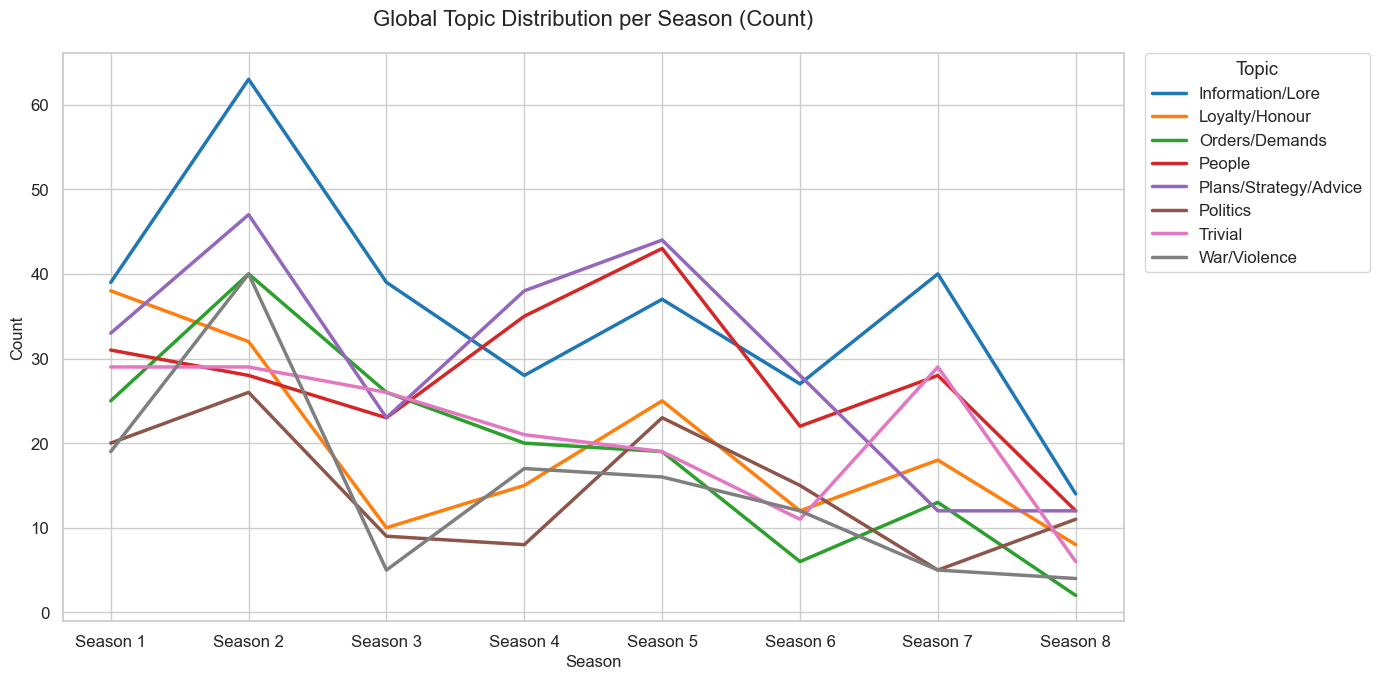

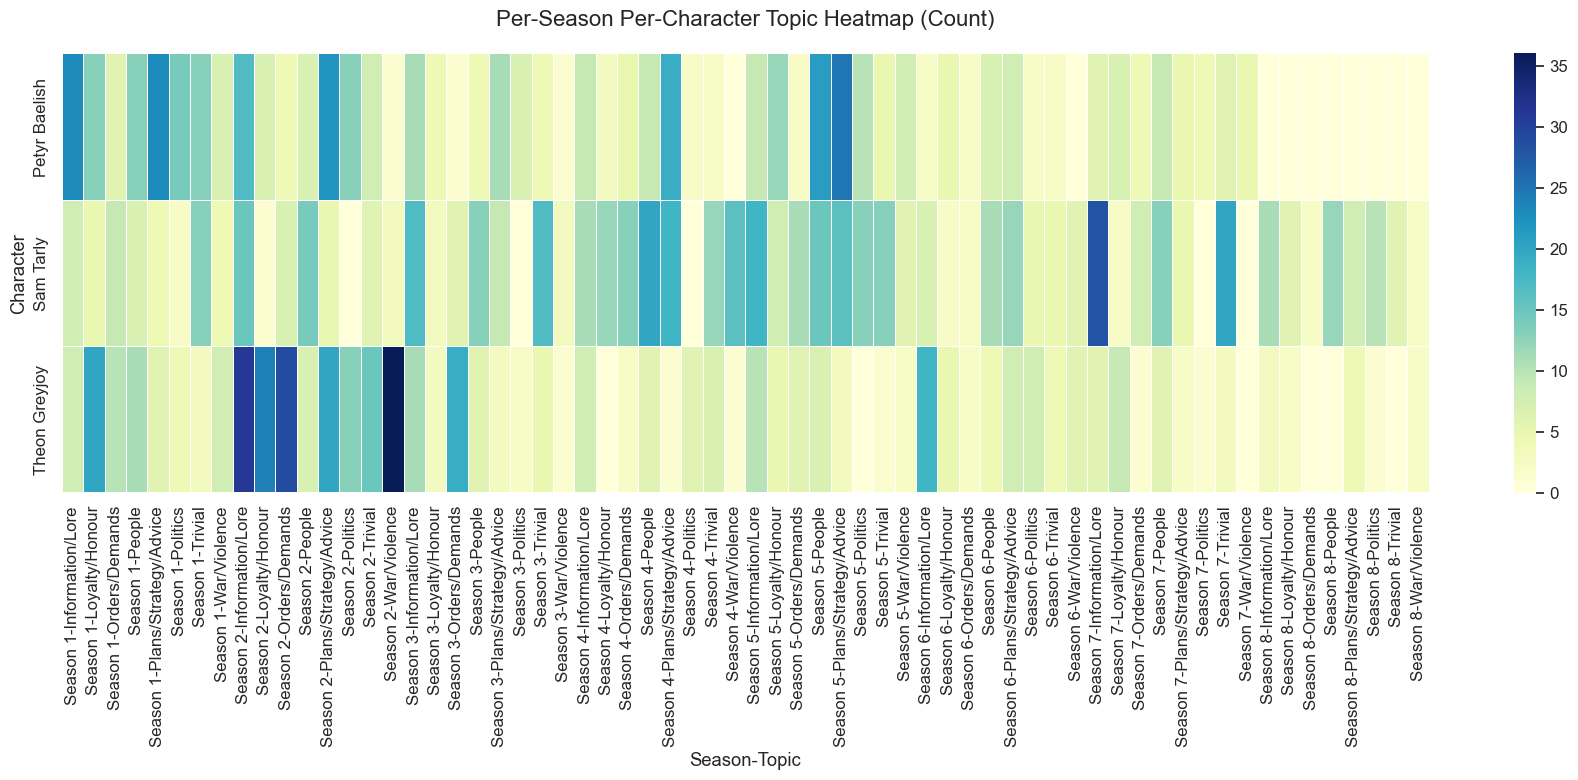

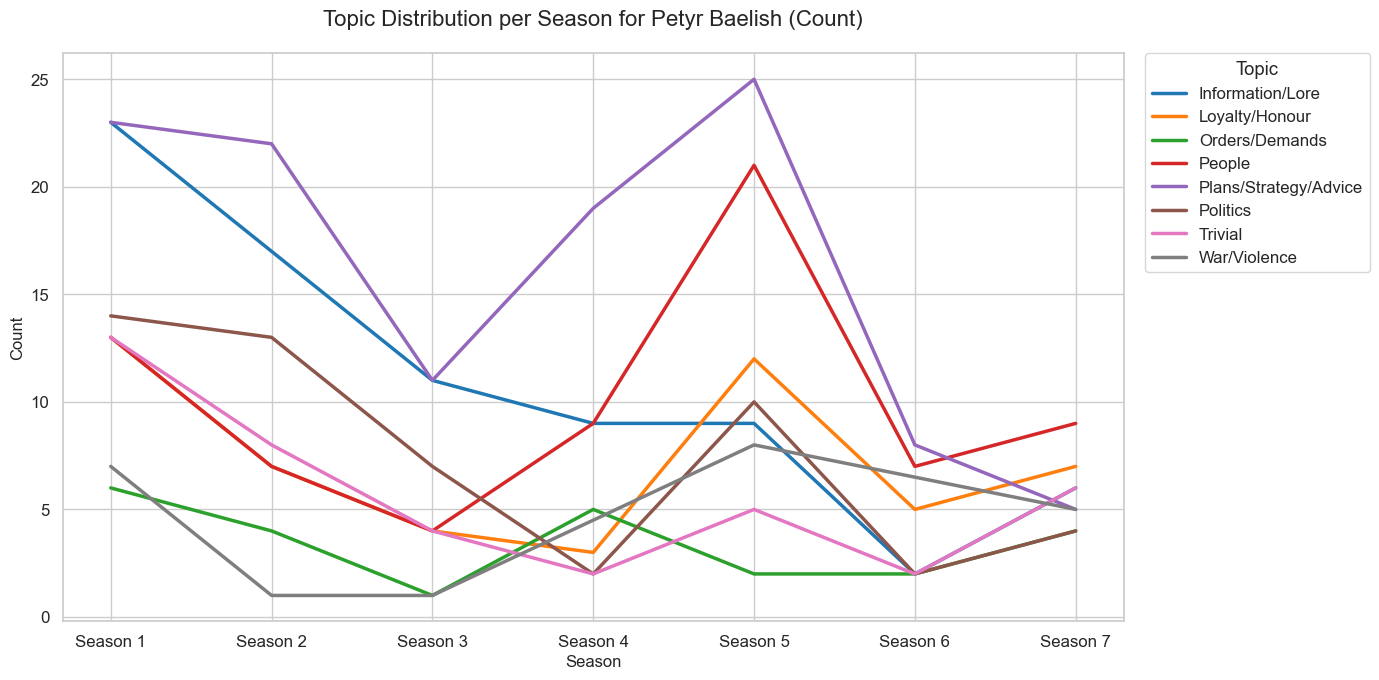

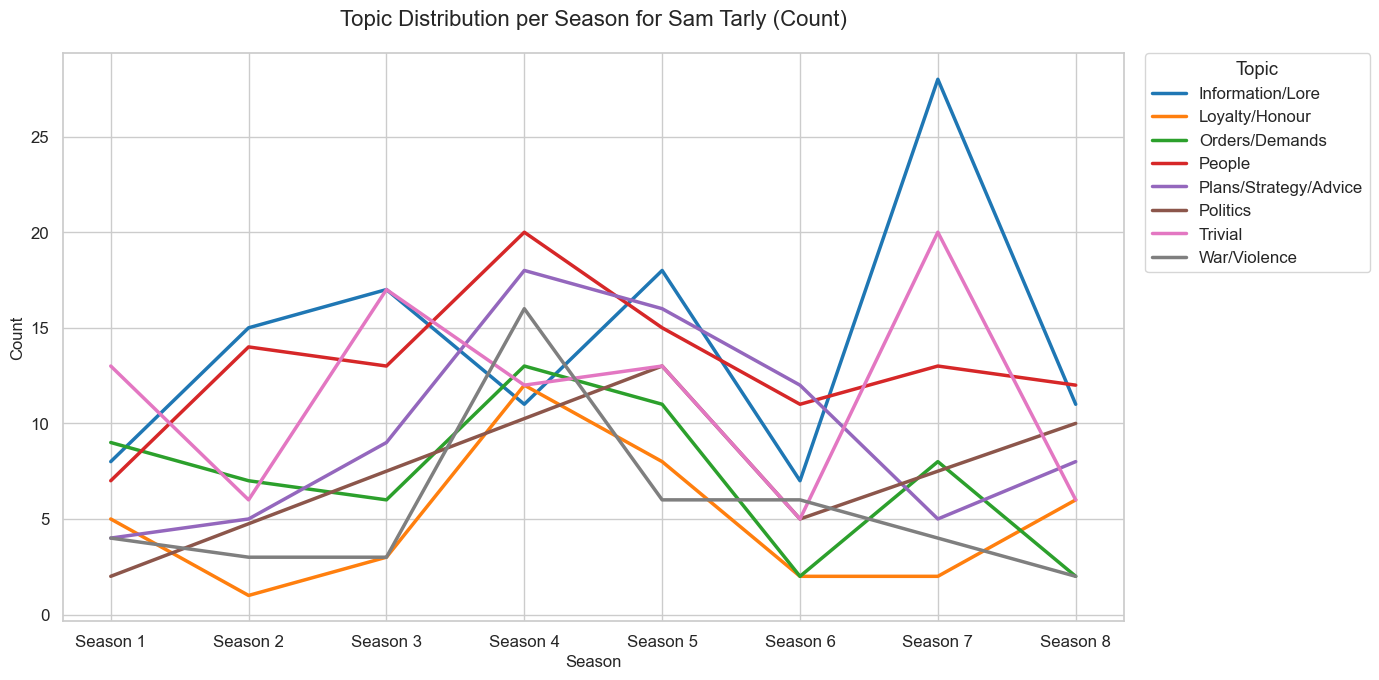

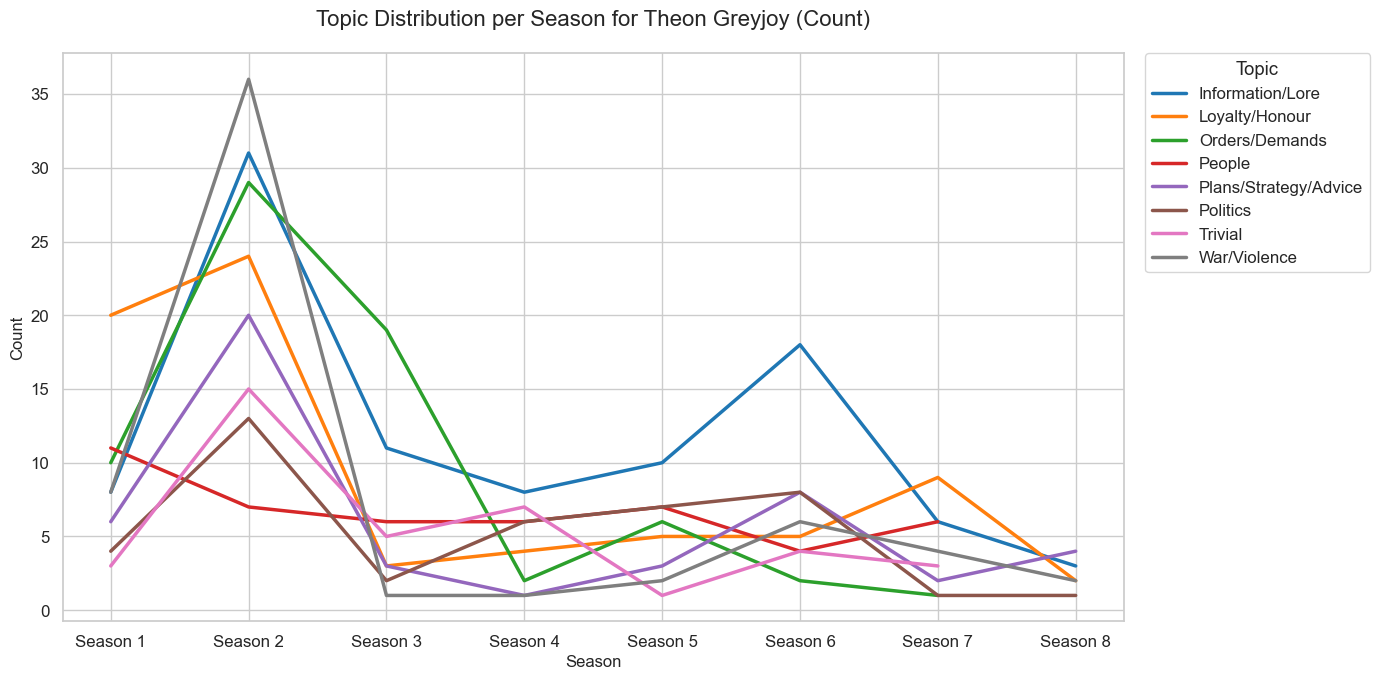

In [13]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and formatting
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams["figure.figsize"] = (14, 7)

# Define consistent color palette for topics
unique_topics = sorted(data["Topic"].unique())
# Use a distinct palette
palette_name = "tab10" if len(unique_topics) <= 10 else "tab20"
colors = sns.color_palette(palette_name, n_colors=len(unique_topics))
topic_colors = dict(zip(unique_topics, colors))

print(f"Topics: {unique_topics}")

# 1. Topic Distribution per Character
topic_per_char_plot = topic_per_char.copy()
# Ensure columns match topic_colors order for correct coloring in pandas plot
topic_per_char_plot = topic_per_char_plot[sorted(topic_per_char_plot.columns)]
topic_colors_list = [topic_colors[t] for t in topic_per_char_plot.columns]

ax = topic_per_char_plot.plot(kind="bar", stacked=False, color=topic_colors_list, figsize=(14, 7))

plt.title("Topic Distribution per Character (Count)", fontsize=16, pad=20)
plt.xlabel("Character", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


# 2. Global Topic Distribution
plt.figure(figsize=(14, 7))
sns.barplot(data=global_topic_dist, x="Topic", y="Count", palette=topic_colors, hue="Topic", legend=False)

plt.title("Global Topic Distribution (Count)", fontsize=16, pad=20)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Global Topic Distribution per Season 
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=global_season_topic,
    x="Season",
    y="Count",
    hue="Topic",
    
    palette=topic_colors,
    linewidth=2.5
)

plt.title("Global Topic Distribution per Season (Count)", fontsize=16, pad=20)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


# 4. Per-Season Per-Character Topic Heatmap 
pivot_heat = per_season_char_topic.pivot_table(
    index="Character",
    columns=["Season", "Topic"],
    values="Count",
    fill_value=0
)

plt.figure(figsize=(18, 8))
sns.heatmap(pivot_heat, cmap="YlGnBu", linewidths=.5)
plt.title("Per-Season Per-Character Topic Heatmap (Count)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()


# 5. Individual Character Topic Distribution per Season
characters = per_season_char_topic["Character"].unique()

for char in characters:
    char_data = per_season_char_topic[per_season_char_topic["Character"] == char]
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=char_data,
        x="Season",
        y="Count",
        hue="Topic",
        
        palette=topic_colors,
        linewidth=2.5
    )
    
    plt.title(f"Topic Distribution per Season for {char} (Count)", fontsize=16, pad=20)
    plt.xlabel("Season", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()

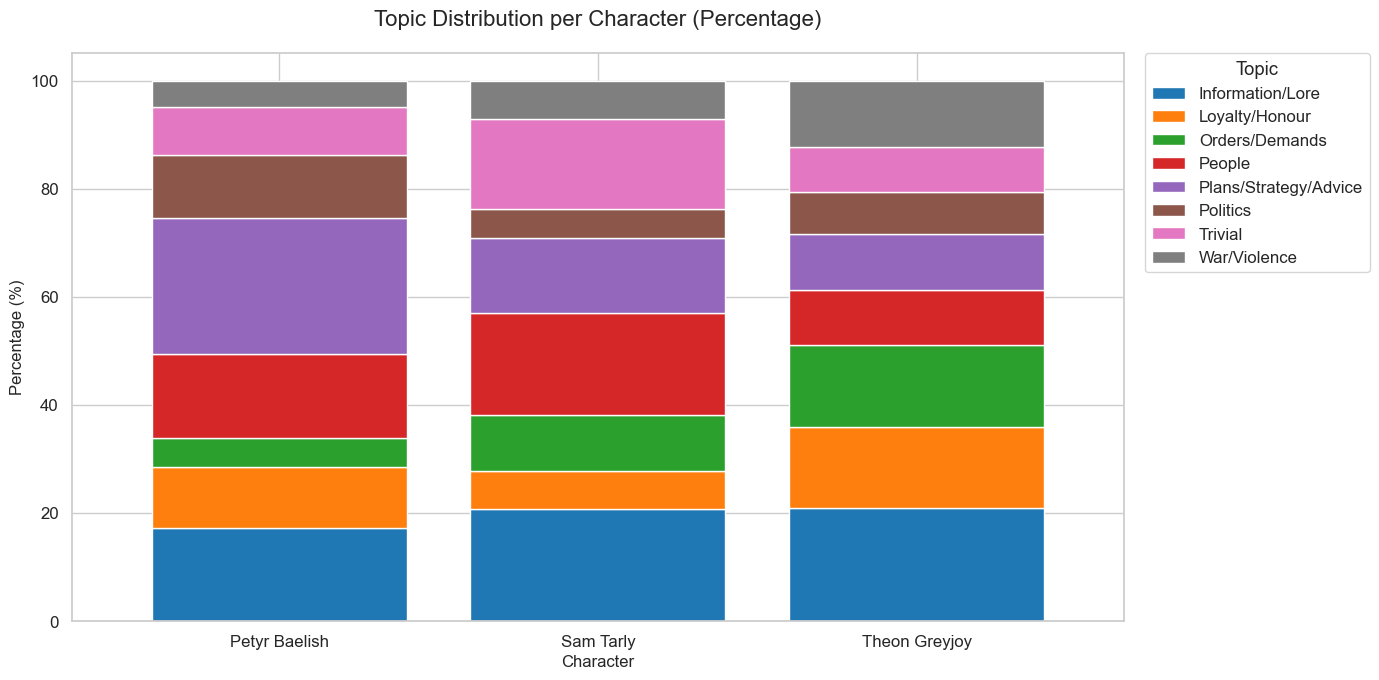

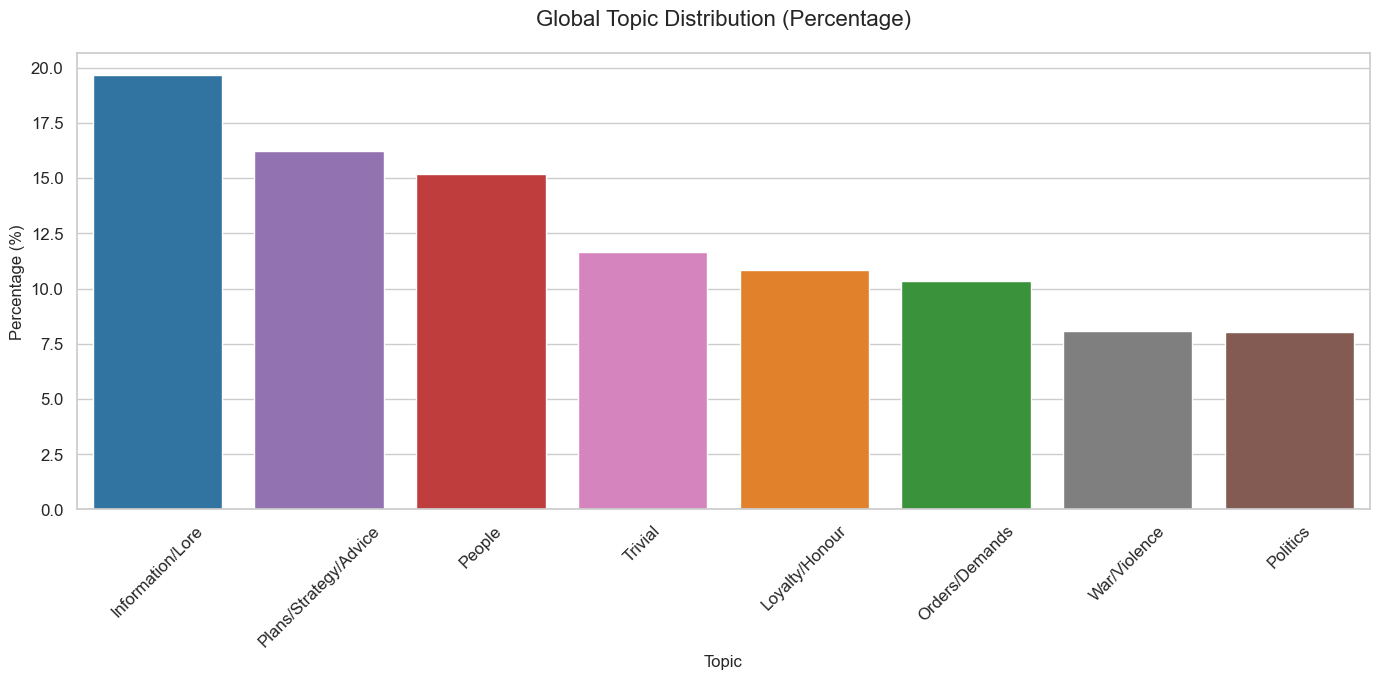

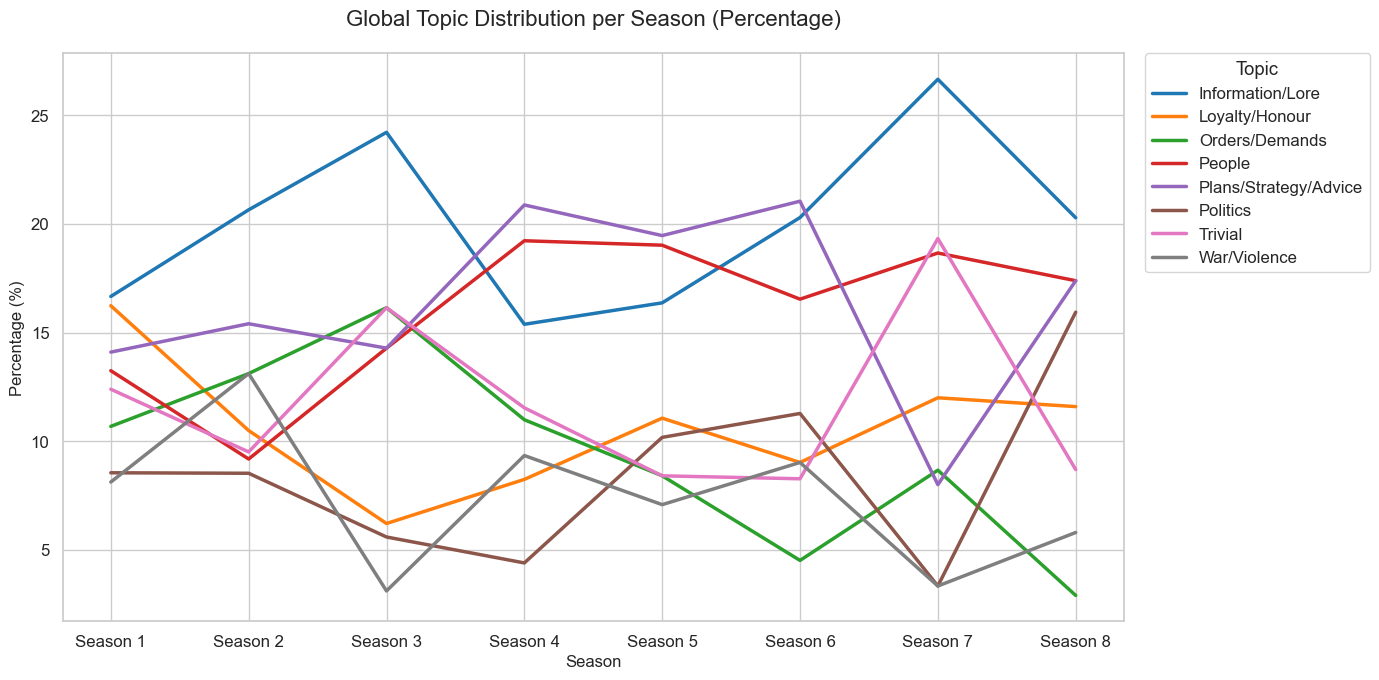

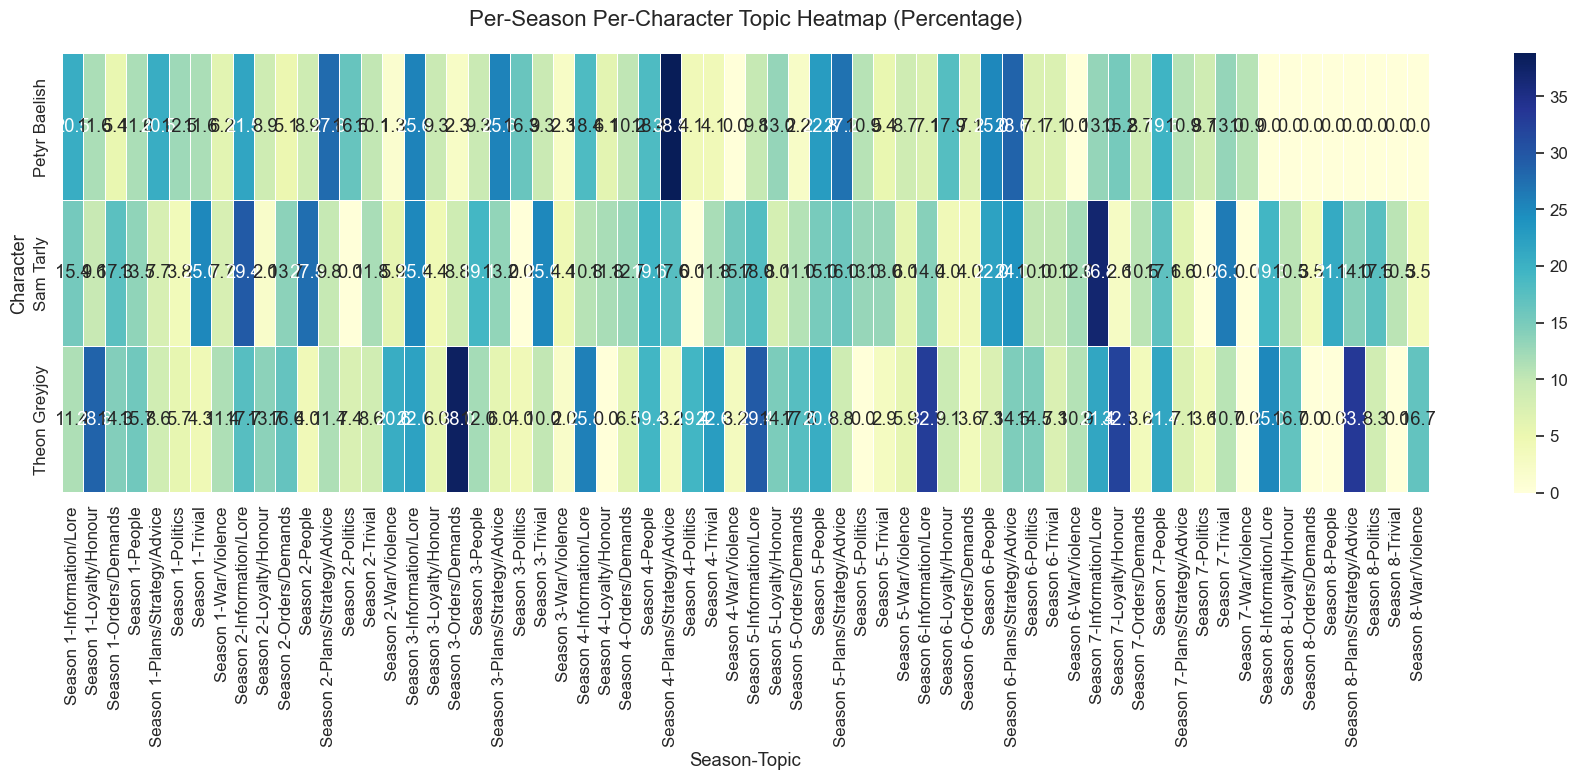

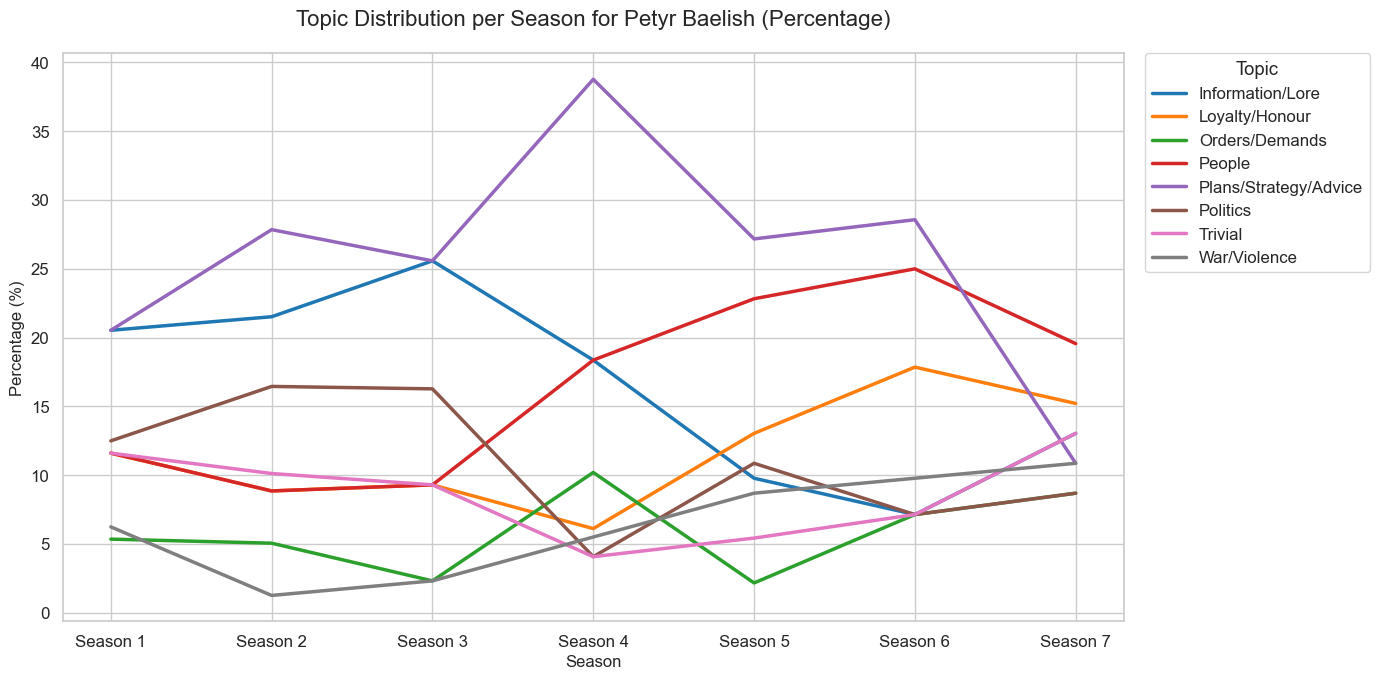

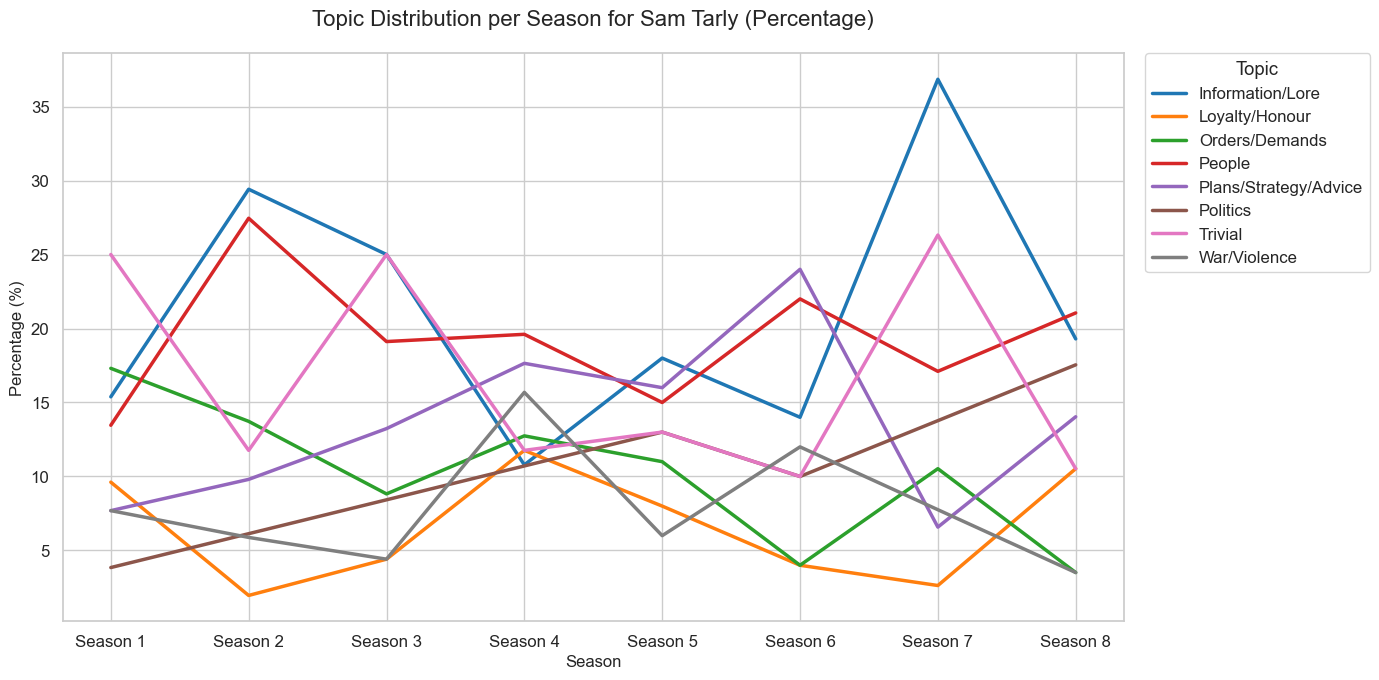

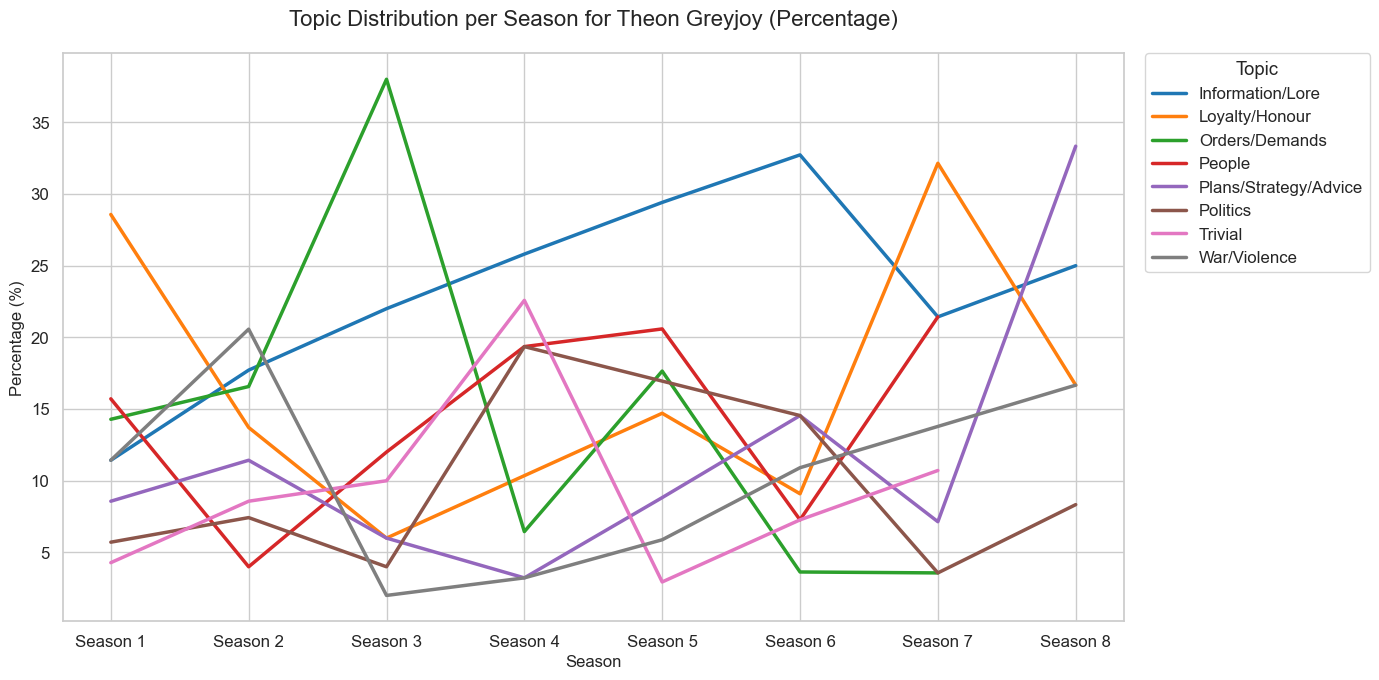

In [12]:
# Visualization in Percentages
# Assuming topic_colors is defined in previous cell, but redefining to be safe if run independently
if 'topic_colors' not in locals():
    unique_topics = sorted(data["Topic"].unique())
    palette_name = "tab10" if len(unique_topics) <= 10 else "tab20"
    colors = sns.color_palette(palette_name, n_colors=len(unique_topics))
    topic_colors = dict(zip(unique_topics, colors))

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# 1. Topic Distribution per Character (Percentage)
topic_per_char_pct = topic_per_char.div(topic_per_char.sum(axis=1), axis=0) * 100
# Sort columns to match colors
topic_per_char_pct = topic_per_char_pct[sorted(topic_per_char_pct.columns)]
topic_colors_list = [topic_colors[t] for t in topic_per_char_pct.columns]

topic_per_char_pct.plot(kind="bar", stacked=True, color=topic_colors_list, figsize=(14, 7), width=0.8)
plt.title("Topic Distribution per Character (Percentage)", fontsize=16, pad=20)
plt.xlabel("Character", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


# 2. Global Topic Distribution (Percentage)
global_topic_dist_pct = global_topic_dist.copy()
global_topic_dist_pct['Percentage'] = global_topic_dist_pct['Count'] / global_topic_dist_pct['Count'].sum() * 100

plt.figure(figsize=(14, 7))
sns.barplot(data=global_topic_dist_pct, x="Topic", y="Percentage", palette=topic_colors, hue="Topic", legend=False)
plt.title("Global Topic Distribution (Percentage)", fontsize=16, pad=20)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Global Topic Distribution per Season (Percentage)
global_season_topic_pct = global_season_topic.copy()
# Calculate percentage per season
global_season_topic_pct['Percentage'] = global_season_topic_pct.groupby('Season')['Count'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=global_season_topic_pct,
    x="Season",
    y="Percentage",
    hue="Topic",
    
    palette=topic_colors,
    linewidth=2.5
)
plt.title("Global Topic Distribution per Season (Percentage)", fontsize=16, pad=20)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


# 4. Per-Season Per-Character Topic Heatmap (Percentage)
per_season_char_topic_pct = per_season_char_topic.copy()
per_season_char_topic_pct['Percentage'] = per_season_char_topic_pct.groupby(['Season', 'Character'])['Count'].transform(lambda x: x / x.sum() * 100)

pivot_heat_pct = per_season_char_topic_pct.pivot_table(
    index="Character",
    columns=["Season", "Topic"],
    values="Percentage",
    fill_value=0
)

plt.figure(figsize=(18, 8))
sns.heatmap(pivot_heat_pct, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1f")
plt.title("Per-Season Per-Character Topic Heatmap (Percentage)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()


# 5. Individual Character Topic Distribution per Season (Percentage)
characters = per_season_char_topic_pct["Character"].unique()

for char in characters:
    char_data = per_season_char_topic_pct[per_season_char_topic_pct["Character"] == char]
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=char_data,
        x="Season",
        y="Percentage",
        hue="Topic",
        
        palette=topic_colors,
        linewidth=2.5
    )
    
    plt.title(f"Topic Distribution per Season for {char} (Percentage)", fontsize=16, pad=20)
    plt.xlabel("Season", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()

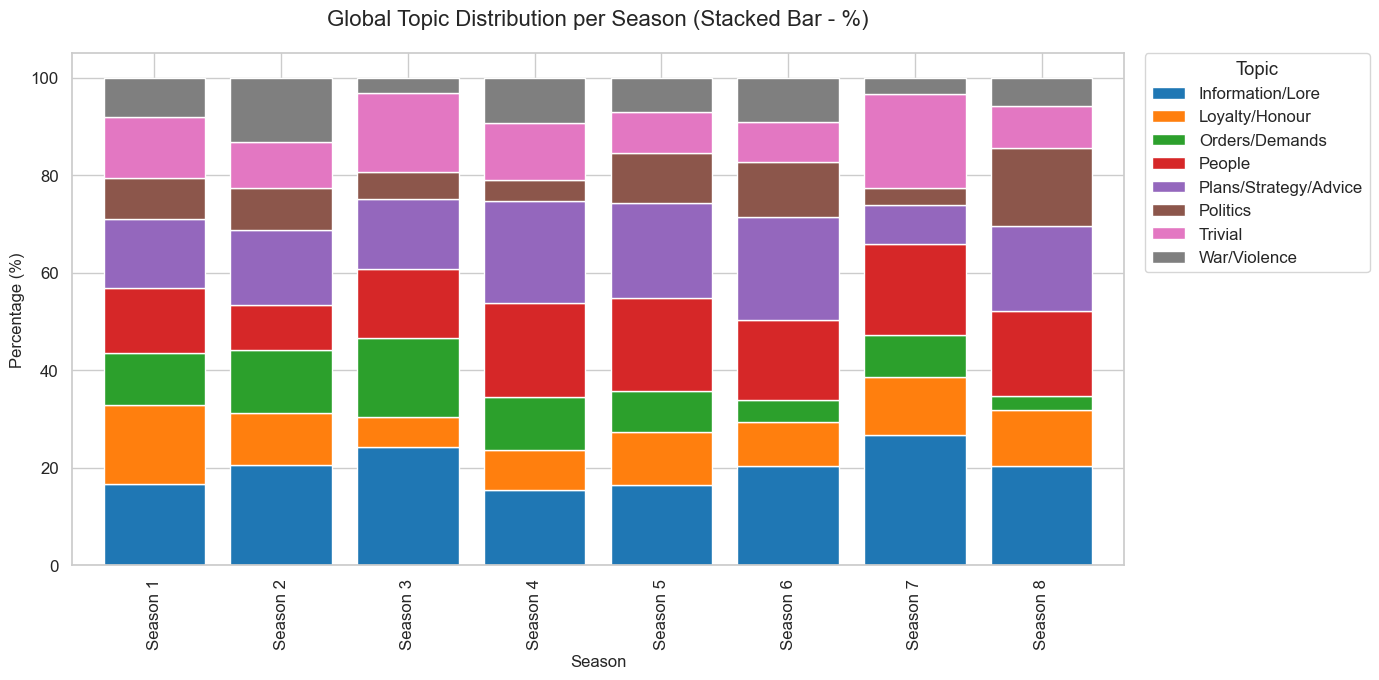

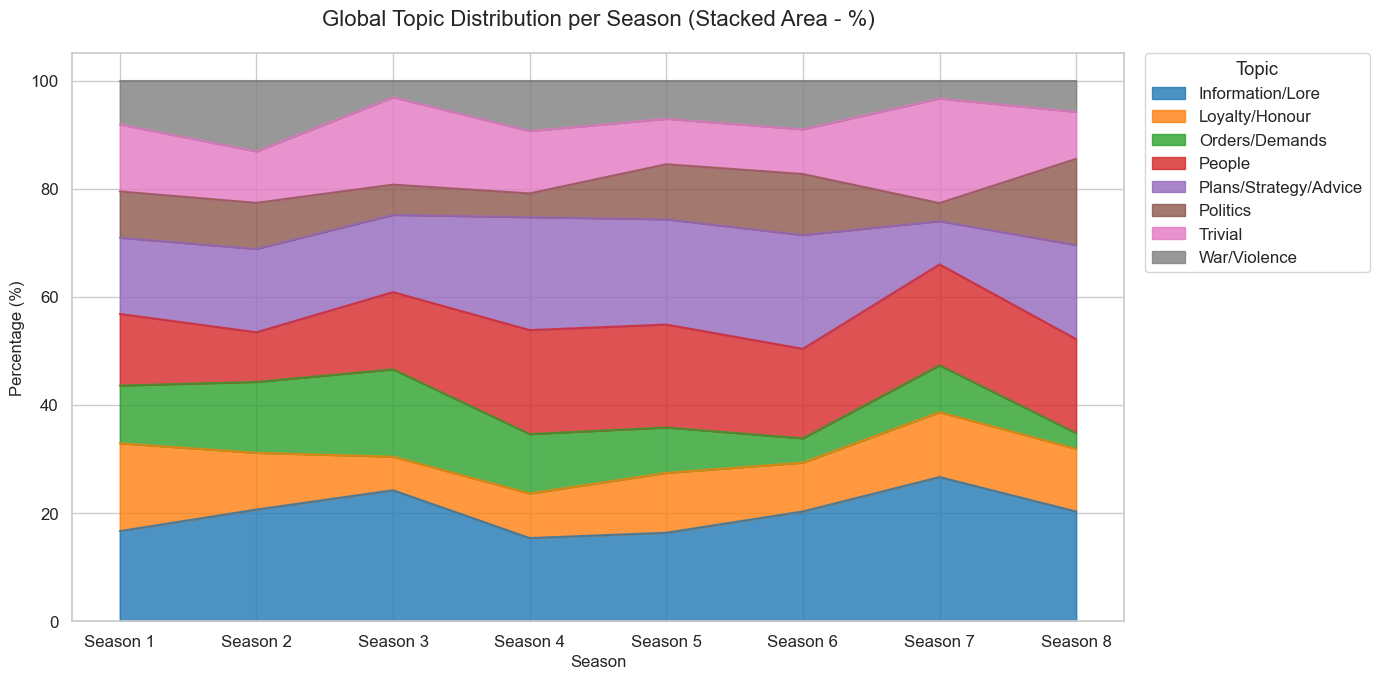

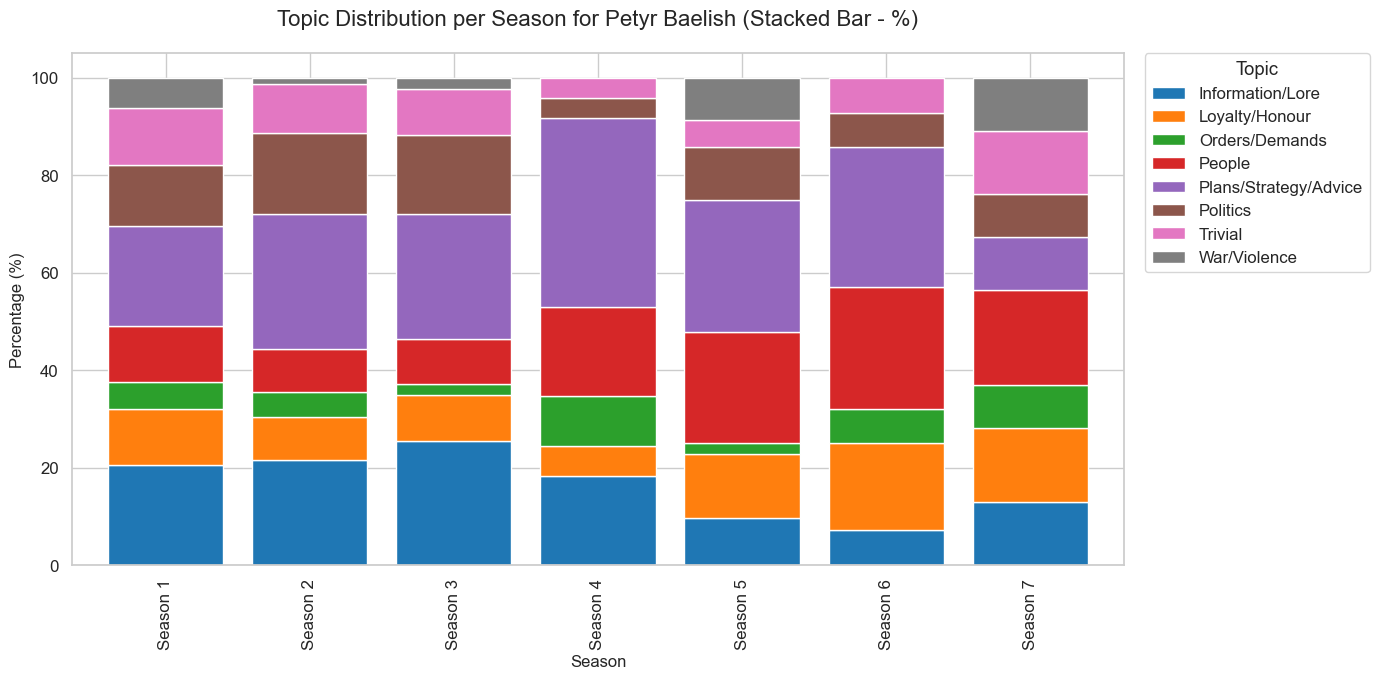

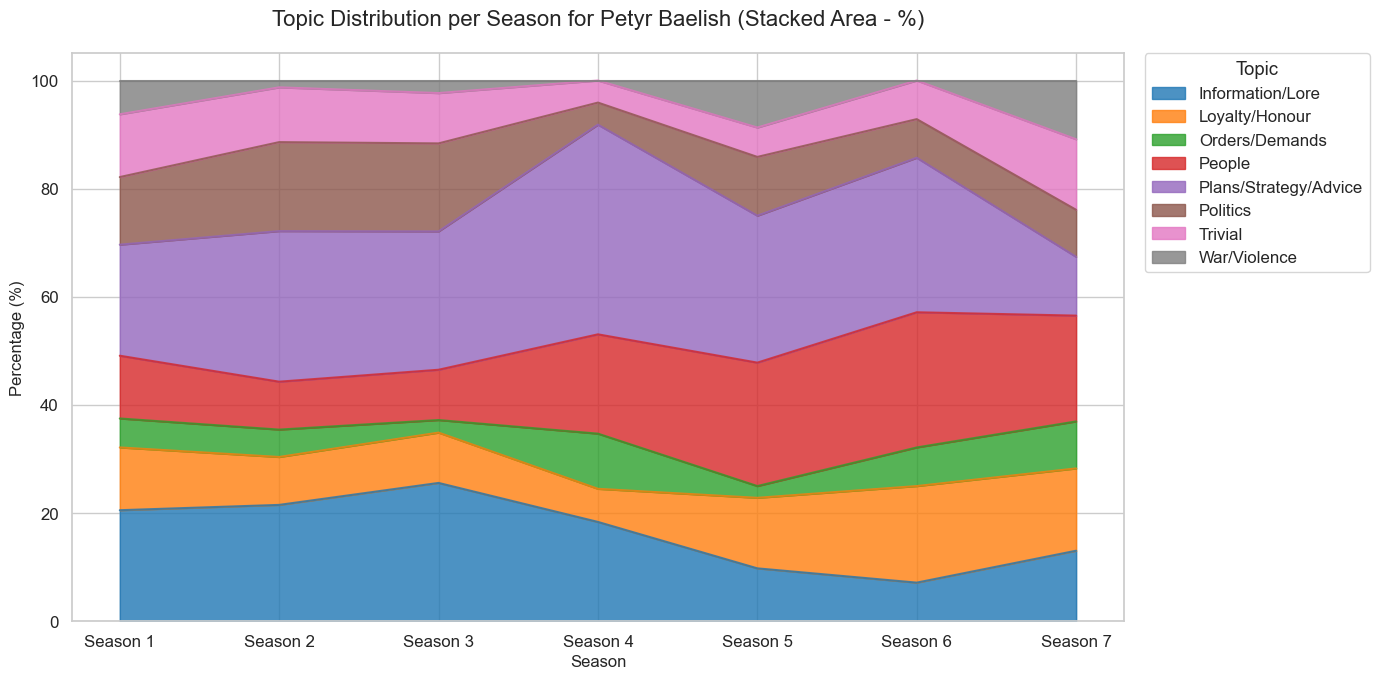

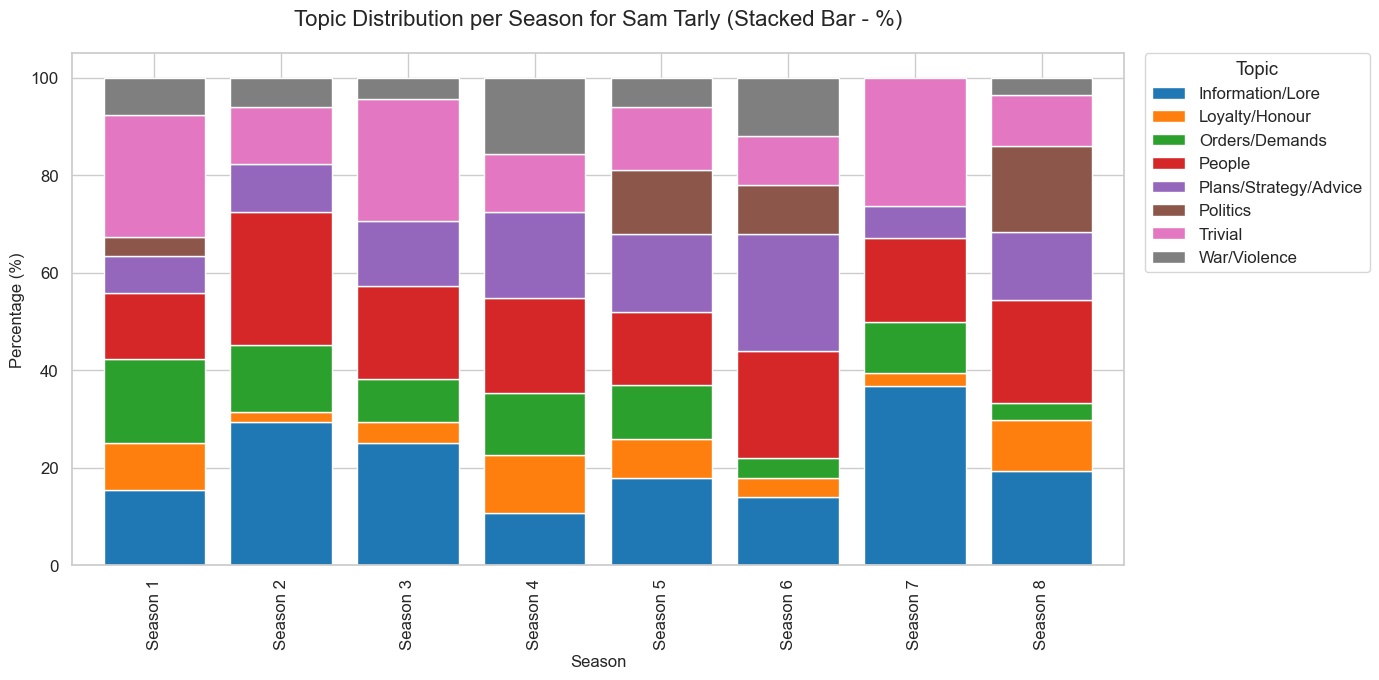

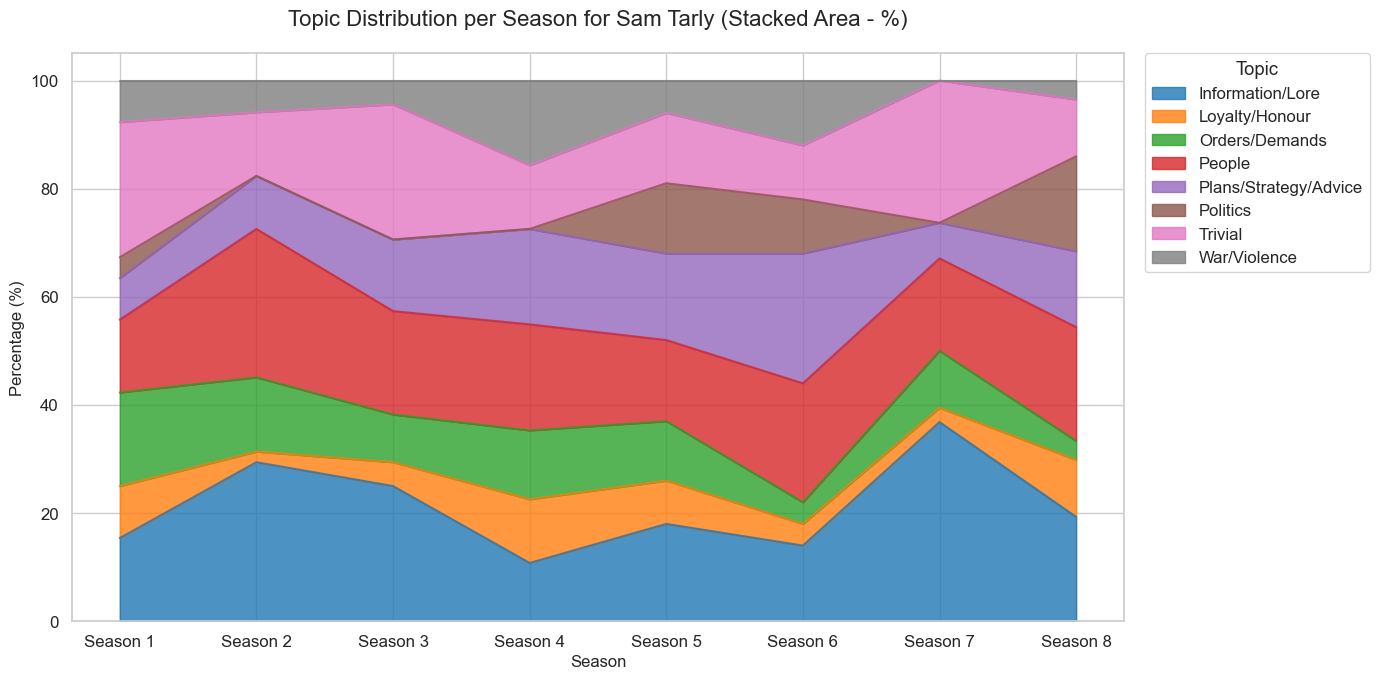

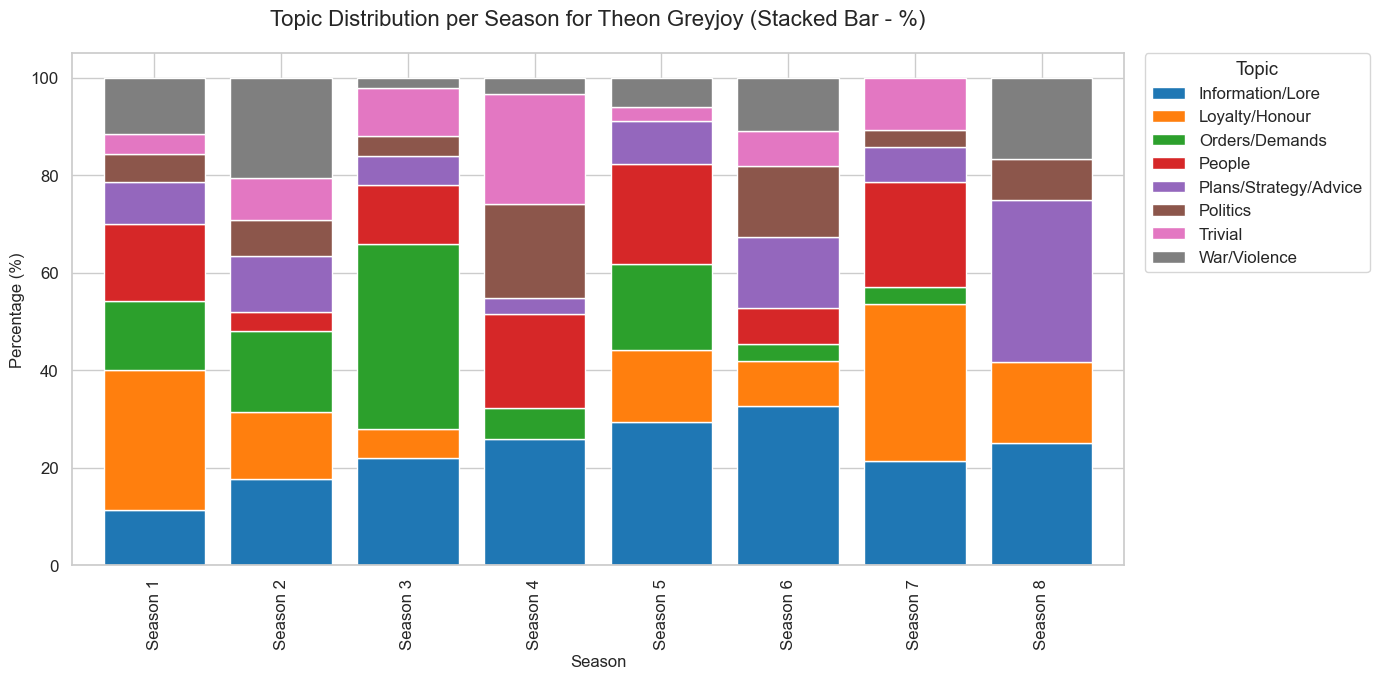

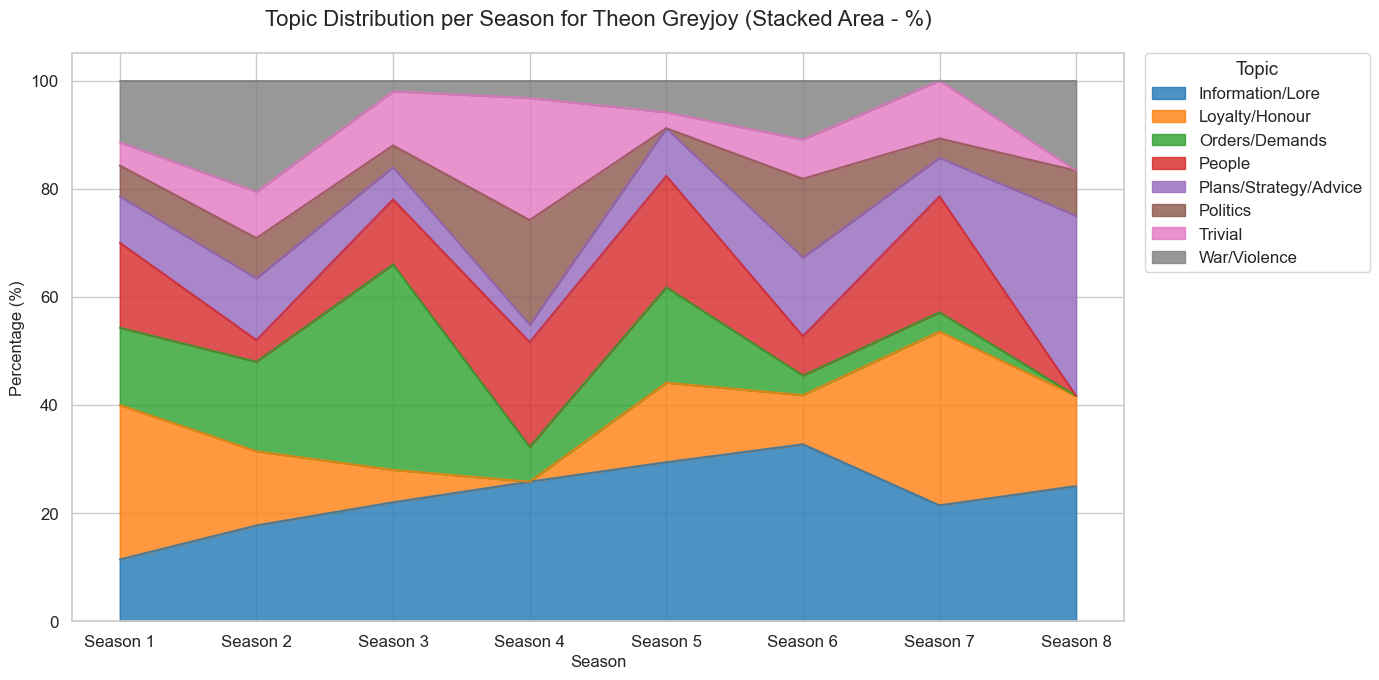

In [14]:
# Stacked Bar and Area Charts
import matplotlib.pyplot as plt

# Ensure consistent colors
if 'topic_colors' not in locals():
    unique_topics = sorted(data["Topic"].unique())
    palette_name = "tab10" if len(unique_topics) <= 10 else "tab20"
    colors = sns.color_palette(palette_name, n_colors=len(unique_topics))
    topic_colors = dict(zip(unique_topics, colors))

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# Global
global_season_pivot = global_season_topic_pct.pivot(index="Season", columns="Topic", values="Percentage").fillna(0)
global_season_pivot = global_season_pivot.sort_index()
# Ensure columns match topic_colors order
global_season_pivot = global_season_pivot[sorted(global_season_pivot.columns)]
global_colors = [topic_colors[t] for t in global_season_pivot.columns]

# 1. Global Topic Distribution per Season (Stacked Bar)
global_season_pivot.plot(kind='bar', stacked=True, color=global_colors, figsize=(14, 7), width=0.8)
plt.title("Global Topic Distribution per Season (Stacked Bar - %)", fontsize=16, pad=20)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

# 2. Global Topic Distribution per Season (Stacked Area)
global_season_pivot.plot(kind='area', stacked=True, color=global_colors, figsize=(14, 7), alpha=0.8)
plt.title("Global Topic Distribution per Season (Stacked Area - %)", fontsize=16, pad=20)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

# Per Character
characters = per_season_char_topic_pct["Character"].unique()

for char in characters:
    char_data = per_season_char_topic_pct[per_season_char_topic_pct["Character"] == char]
    char_pivot = char_data.pivot(index="Season", columns="Topic", values="Percentage").fillna(0)
    char_pivot = char_pivot.sort_index()
    # Ensure columns match topic_colors order
    char_pivot = char_pivot[sorted(char_pivot.columns)]
    char_colors = [topic_colors[t] for t in char_pivot.columns]
    
    # 3. Character Topic Distribution per Season (Stacked Bar)
    char_pivot.plot(kind='bar', stacked=True, color=char_colors, figsize=(14, 7), width=0.8)
    plt.title(f"Topic Distribution per Season for {char} (Stacked Bar - %)", fontsize=16, pad=20)
    plt.xlabel("Season", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()

    # 4. Character Topic Distribution per Season (Stacked Area)
    char_pivot.plot(kind='area', stacked=True, color=char_colors, figsize=(14, 7), alpha=0.8)
    plt.title(f"Topic Distribution per Season for {char} (Stacked Area - %)", fontsize=16, pad=20)
    plt.xlabel("Season", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()

In [17]:
print("\n=== Top 10 TF-IDF terms per Topic ===")
for topic in topic_labels:
    print(f"\n### Topic: {topic}")
    display(
        top_terms_df[top_terms_df["Topic"] == topic]
        .sort_values("TFIDF", ascending=False)
        .head(top_n)
    )



=== Top 10 TF-IDF terms per Topic ===

### Topic: Information/Lore


,Topic,Term,TFIDF
0,Information/Lore,wall,0.142306
1,Information/Lore,night,0.139368
2,Information/Lore,citadel,0.128352
3,Information/Lore,high,0.127493
4,Information/Lore,escape,0.126771
5,Information/Lore,saw,0.114028
6,Information/Lore,took,0.112536
7,Information/Lore,dragonglass,0.106244
8,Information/Lore,ice,0.101417
9,Information/Lore,wanted,0.099614



### Topic: Loyalty/Honour


,Topic,Term,TFIDF
10,Loyalty/Honour,serve,0.174576
11,Loyalty/Honour,promise,0.168591
12,Loyalty/Honour,save,0.168591
13,Loyalty/Honour,help,0.135489
14,Loyalty/Honour,honor,0.134873
15,Loyalty/Honour,defend,0.134873
16,Loyalty/Honour,yara,0.127554
17,Loyalty/Honour,queen,0.127554
18,Loyalty/Honour,gave,0.127554
19,Loyalty/Honour,failed,0.120698



### Topic: Orders/Demands


,Topic,Term,TFIDF
20,Orders/Demands,stop,0.243391
21,Orders/Demands,inside,0.183826
22,Orders/Demands,mercy,0.164506
23,Orders/Demands,leave,0.153888
24,Orders/Demands,wait,0.139080
25,Orders/Demands,safe,0.139080
26,Orders/Demands,hear,0.137009
27,Orders/Demands,speak,0.118970
28,Orders/Demands,pyp,0.118970
29,Orders/Demands,alright,0.118970



### Topic: People


,Topic,Term,TFIDF
30,People,reek,0.491800
31,People,beautiful,0.207073
32,People,theon,0.160710
33,People,archmaester,0.155305
34,People,petyr,0.143166
35,People,arryn,0.129421
36,People,thing,0.125198
37,People,children,0.113474
38,People,brienne,0.107375
39,People,warrior,0.107375



### Topic: Plans/Strategy/Advice


,Topic,Term,TFIDF
40,Plans/Strategy/Advice,make,0.211564
41,Plans/Strategy/Advice,north,0.186674
42,Plans/Strategy/Advice,safe,0.157913
43,Plans/Strategy/Advice,return,0.149426
44,Plans/Strategy/Advice,help,0.125802
45,Plans/Strategy/Advice,try,0.111824
46,Plans/Strategy/Advice,fight,0.108063
47,Plans/Strategy/Advice,happy,0.104359
48,Plans/Strategy/Advice,need,0.099559
49,Plans/Strategy/Advice,black,0.099559



### Topic: Politics


,Topic,Term,TFIDF
50,Politics,grace,0.396038
51,Politics,queen,0.279633
52,Politics,aegon,0.176402
53,Politics,realm,0.139817
54,Politics,marrying,0.132302
55,Politics,single,0.132302
56,Politics,north,0.132225
57,Politics,crown,0.127573
58,Politics,heir,0.127573
59,Politics,tywin,0.127573



### Topic: Trivial


,Topic,Term,TFIDF
60,Trivial,walks,0.250289
61,Trivial,work,0.167809
62,Trivial,turns,0.167809
63,Trivial,sam,0.158703
64,Trivial,jr,0.150173
65,Trivial,knife,0.150173
66,Trivial,looks,0.144805
67,Trivial,library,0.144805
68,Trivial,door,0.125857
69,Trivial,steps,0.125857



### Topic: War/Violence


,Topic,Term,TFIDF
70,War/Violence,kill,0.341430
71,War/Violence,killed,0.297787
72,War/Violence,walker,0.190046
73,War/Violence,white,0.160673
74,War/Violence,killing,0.132728
75,War/Violence,war,0.114533
76,War/Violence,throat,0.114533
77,War/Violence,gregor,0.106182
78,War/Violence,took,0.100420
79,War/Violence,arrows,0.095023


=== TF-IDF Scores (Text List Format) ===

Topic: Information/Lore
wall (0.142), night (0.139), citadel (0.128), high (0.127), escape (0.127), saw (0.114), took (0.113), dragonglass (0.106), ice (0.101), wanted (0.100)

Topic: Loyalty/Honour
serve (0.175), promise (0.169), save (0.169), help (0.135), honor (0.135), defend (0.135), yara (0.128), queen (0.128), gave (0.128), failed (0.121)

Topic: Orders/Demands
stop (0.243), inside (0.184), mercy (0.165), leave (0.154), wait (0.139), safe (0.139), hear (0.137), speak (0.119), pyp (0.119), alright (0.119)

Topic: People
reek (0.492), beautiful (0.207), theon (0.161), archmaester (0.155), petyr (0.143), arryn (0.129), thing (0.125), children (0.113), brienne (0.107), warrior (0.107)

Topic: Plans/Strategy/Advice
make (0.212), north (0.187), safe (0.158), return (0.149), help (0.126), try (0.112), fight (0.108), happy (0.104), need (0.100), black (0.100)

Topic: Politics
grace (0.396), queen (0.280), aegon (0.176), realm (0.140), marrying (

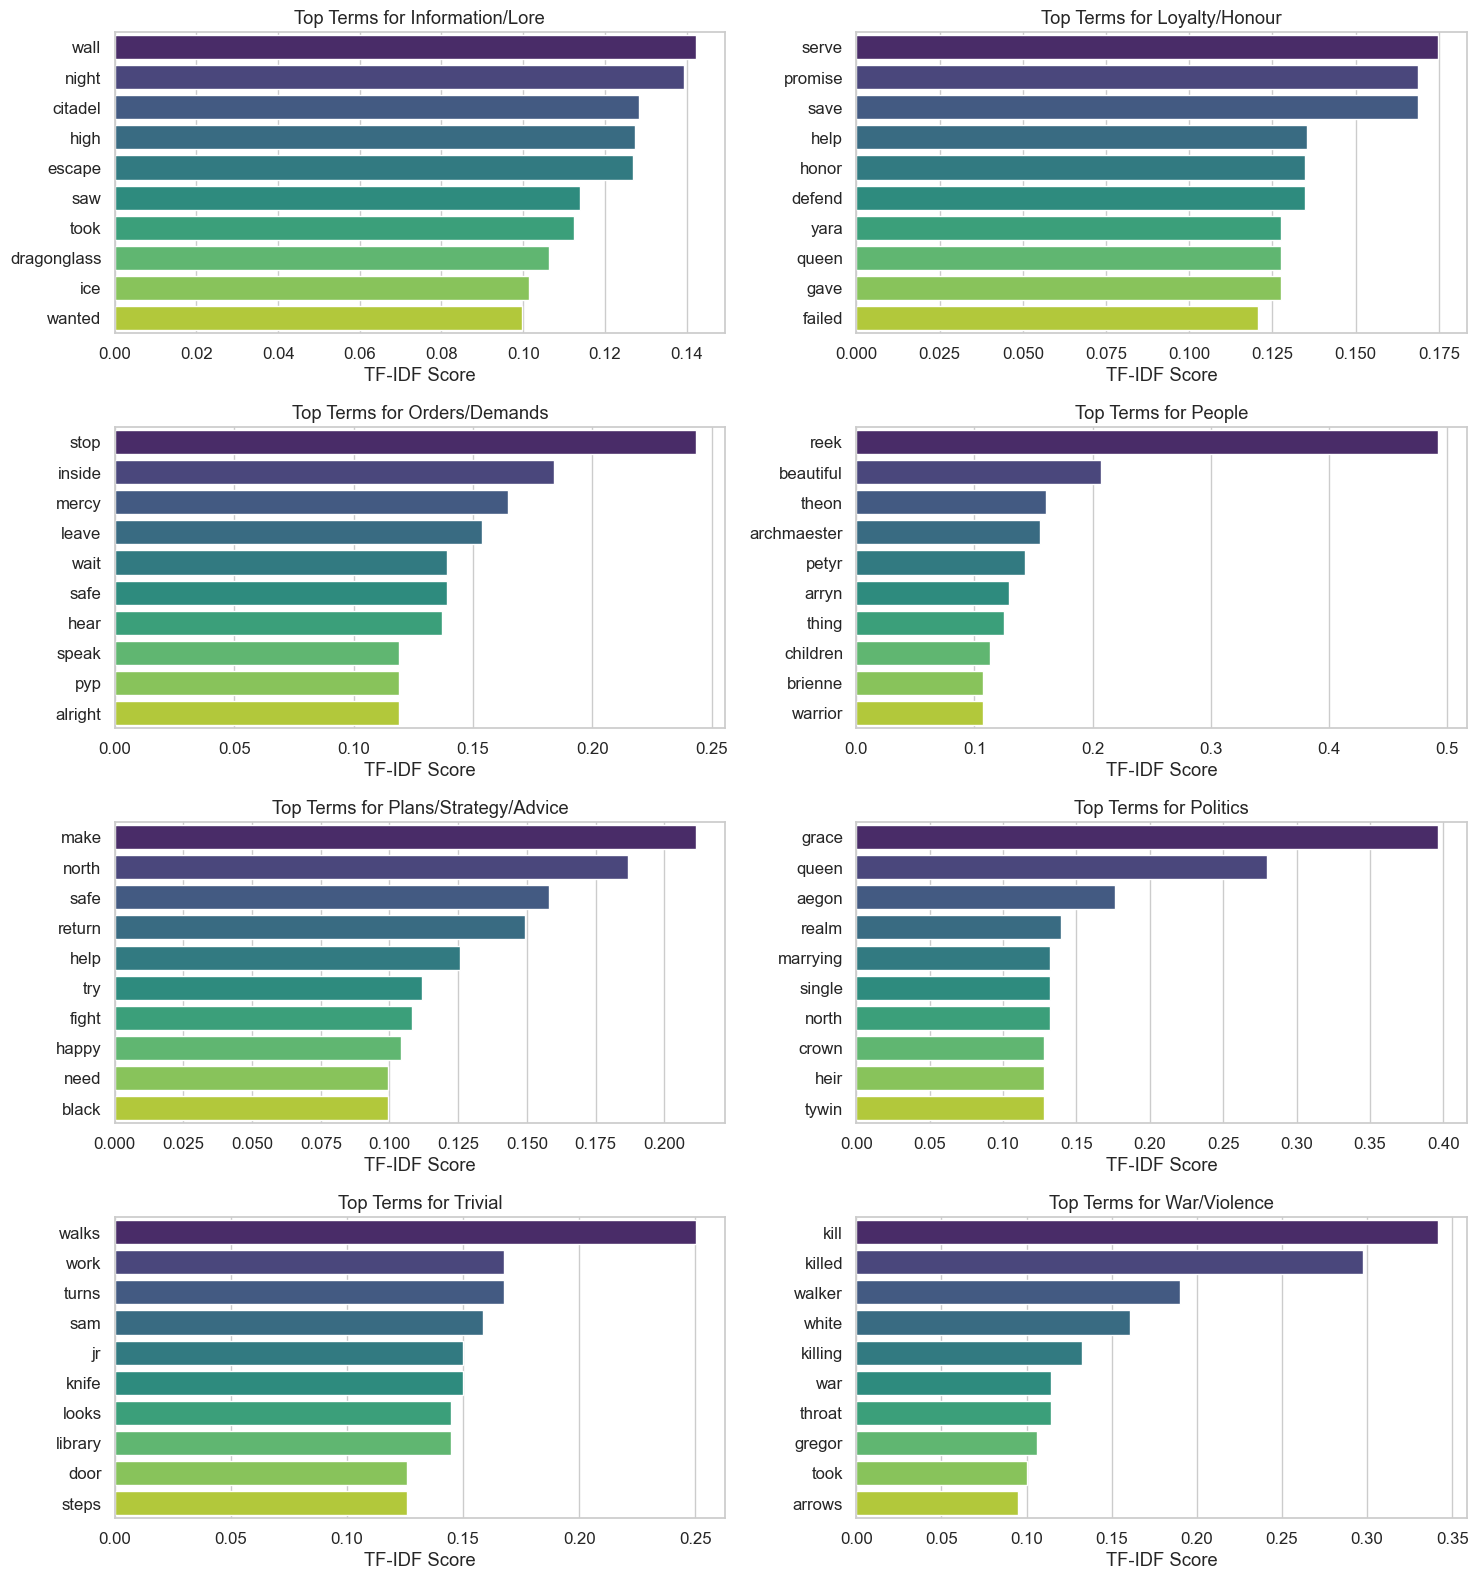

In [18]:
# TF-IDF Technical Report Formats
import math

# Ensure top_terms_df exists (from previous cell)
if 'top_terms_df' in locals():
    unique_topics = top_terms_df["Topic"].unique()
    
    # --- Option 1: Text List Format ---
    print("=== TF-IDF Scores (Text List Format) ===")
    for topic in unique_topics:
        # Get top 10 terms for this topic
        subset = top_terms_df[top_terms_df["Topic"] == topic].sort_values("TFIDF", ascending=False).head(10)
        
        # Format: word (score), word (score)
        formatted_list = ", ".join([f"{row['Term']} ({row['TFIDF']:.3f})" for _, row in subset.iterrows()])
        
        print(f"\nTopic: {topic}")
        print(formatted_list)
        
    # --- Option 2: Graph Format ---
    print("\n\n=== TF-IDF Scores (Graph Format) ===")
    
    # Setup subplots
    n_topics = len(unique_topics)
    n_cols = 2
    n_rows = math.ceil(n_topics / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()
    
    for i, topic in enumerate(unique_topics):
        subset = top_terms_df[top_terms_df["Topic"] == topic].sort_values("TFIDF", ascending=False).head(10)
        
        sns.barplot(data=subset, x="TFIDF", y="Term", ax=axes[i], palette="viridis", hue="Term", legend=False)
        axes[i].set_title(f"Top Terms for {topic}")
        axes[i].set_xlabel("TF-IDF Score")
        axes[i].set_ylabel("")
        
    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()
else:
    print("Error: 'top_terms_df' not found. Please run the TF-IDF calculation cell first.")